In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.v2 import ToTensor, Lambda

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Defining transform

In [ ]:
MEAN = [0.5450, 0.4435, 0.3436]
STD = [0.2302, 0.2409, 0.2387]
# Transform to convert images and resize them, so we could use pre-trained models
# Note apply only to the training set!
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [ ]:
def data_loading():
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

data_loading()

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
    train_data = datasets.Food101(
        root="data",
        split="train",
        download=True,
        transform=transform
    )

    test_data = datasets.Food101(
        root="data",
        split="test",
        download=True,
        transform=ToTensor(),
        target_transform = None
    )

In [ ]:
len(train_data), len(test_data)

(75750, 25250)

We have 75750 training images and 25250 testing images

In [ ]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 23)

In [ ]:
print(f"Image shape: {image.shape}")
print(f"Class label: {class_names[label]}")

Image shape: torch.Size([3, 224, 224])
Class label: churros


# Visualize image

In [ ]:
print(image.squeeze().shape)

torch.Size([3, 224, 224])


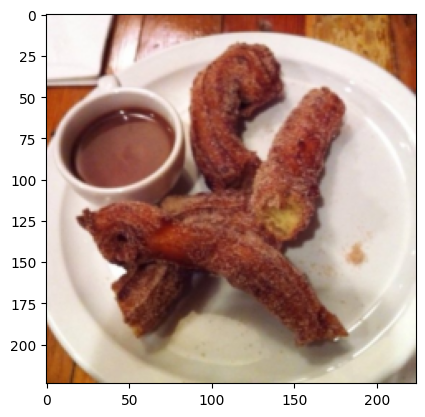

In [ ]:
# transform an image from (C, H, W) to (H, W, C) to visualize it
image_permute = image.permute(1, 2, 0)
plt.imshow(image_permute)

# Plot random images

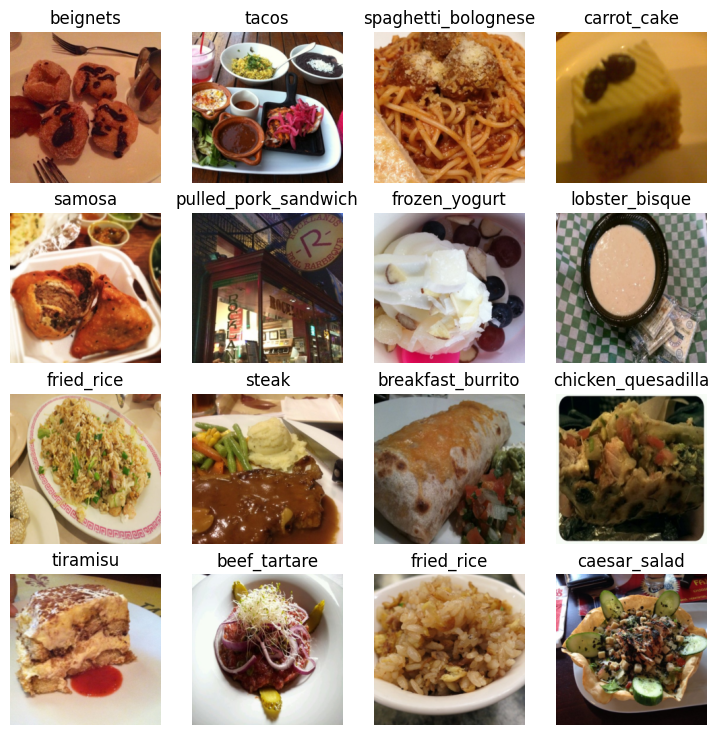

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis("off")

### Calculates global normalization stastics.
This will help to normalize pixel values, increase convergence of a model

In [ ]:
"""
from tqdm import tqdm
train_loader = DataLoader(train_data, batch_size=32, num_workers=2, shuffle=True)

mean = torch.zeros(3, device=device)
std = torch.zeros(3, device=device)
nb_samples = 0.

for data, _ in tqdm(train_loader, total=len(train_loader)):
    # Put data to GPU
    data = data.to(device)
    batch_samples = data.size(0)
    # Flatten height and width
    data = data.view(batch_samples, data.size(1), -1)
    # Calculate mean and std
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Calculate global mean and std
mean /= nb_samples
std /= nb_samples

print("Global Mean:", mean)
print("Global Std:", std)
"""

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 2368/2368 [06:00<00:00,  6.57it/s]


Global Mean: tensor([0.5450, 0.4435, 0.3436], device='cuda:0')
Global Std: tensor([0.2302, 0.2409, 0.2387], device='cuda:0')
